# **Finite difference method for solving Black-Scholes PDE**

To price a European option with payoff function $(S_T-K)^{+}$ under Black-Scholes model, we need to solve the PDE

\begin{align}
\frac{\partial V}{\partial \tau}&=\frac{\sigma(\tau, s)^2 s^2}{2}\frac{\partial^2 V}{\partial s^2} + rs\frac{\partial V}{\partial s} -rV,& \tau>0 \\
V(0,s)&= g(s) = (s-K)^{+},& \tau=0
\end{align}

$$\sigma(\tau, s) = (1 + \frac{T - \tau}{30})(0.1 + 0.4 * \exp(-\frac{s}{50}))$$


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt

# Market and option parameters
K, r, T = 100, 0.01, 1

# *Setup of the grid and boundary condition*

*Boundary condition*

In this example we will work with the domain of $(\tau,s)$ directly which is truncated to $D:=[0,T]\times [s_{min},s_{max}]$. Since a call option is involved, we impose the boundary conditions
\begin{align}
V(\tau,s_{min})=\ell(\tau,s_{min})=0,\qquad V(\tau,s_{max})=u(\tau,s_{max})=s_{max}-Ke^{-r\tau} \qquad \text{for all } \tau<T
\end{align}
<br>
<br>
*Grid specification*

We construct a uniform grid over $D$ with $N+1$ points along the time dimension and $M+1$ points along the space dimension. Let
\begin{align*}
\triangle \tau:=\frac{T}{N},\qquad \triangle x:=\frac{s_{max}-s_{min}}{M}.
\end{align*}
Then the values of the grid points are given by
\begin{align*}
\tau_n&:=n\triangle t,& n=0,1,...,N \\
s_k&:=s_{min}+k\triangle x,& k=0,1,...,M
\end{align*}

In [2]:
# Grid parameters
s_min, s_max = 10, 300
N, M = 1000, 290  # we want the grid of x to be 5 

# Setup of grids
dtau = T/N
dx = (s_max - s_min)/M
s = np.linspace(s_min, s_max, M+1)
tau = np.linspace(0, T, N+1)

# *Explicit scheme*

Under explicit scheme the PDE can be discretised as

\begin{align*}
V^{n+1}_k&=A^{n}_k V^n_{k-1} +(1+B^{n}_k) V^n_{k}+C^{n}_k V^n_{k+1}
\end{align*}
for $k=1, 2, ..., M-1$, where
\begin{align}
A^{n}_k:=\frac{\triangle \tau}{\triangle x^2}\frac{\sigma(\tau_n, s_k)^2 s_k^2}{2}-\frac{\triangle \tau}{2\triangle x}rs_k,\qquad B^{n}_k:=-\frac{ \triangle \tau}{\triangle x^2}\sigma(\tau_n, s_k)^2 s_k^2-\triangle \tau r,\qquad C^{n}_k:=\frac{\triangle \tau}{\triangle x^2}\frac{\sigma(\tau_n, s_k)^2 s_k^2}{2}+\frac{\triangle \tau}{2\triangle x}rs_k
\end{align}

Recall that the $M-1$ recursive equations can be summarised using matrix notation
\begin{align*}
\underbrace{
\begin{bmatrix}
V^{n+1}_0 \\ 
V^{n+1}_1 \\ 
V^{n+1}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n+1}_{M-1}\\ 
V^{n+1}_M  
\end{bmatrix}}_{=:V^{n+1}}
=
\underbrace{
\begin{bmatrix}
1 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
A^n_1 & 1+B^n_1 & C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & A^n_2 & 1+B^n_2 &C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & A^n_{M-2} &  1+B^n_{M-2}& C^n_{M-2}& 0\\ 
 &  &  &  &  &0 & A^n_{M-1} & 1+B^n_{M-1} & C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &1 
\end{bmatrix}}_{=:\mathbb{I}+L^n}
\underbrace{
\begin{bmatrix}
V^{n}_0 \\ 
V^{n}_1 \\ 
V^{n}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n}_{M-1}\\ 
V^{n}_M  
\end{bmatrix}}_{=:V^{n}}
\end{align*}
Here $\mathbb{I}$ is an $(M+1)\times (M+1)$ identity matrix and $L^n$ is an $(M+1)\times (M+1)$ matrix in form of
\begin{align}
L^n:=
\begin{bmatrix}
0 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
A^n_1 & B^n_1 & C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & A^n_2 & B^n_2 &C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & A^n_{M-2} &  B^n_{M-2}& C^n_{M-2}& 0\\ 
 &  &  &  &  &0 & A^n_{M-1} & B^n_{M-1} & C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &0
\end{bmatrix}
\end{align}

In our specific example, $A$, $B$ and $C$ (and in turn the matrix $L$) have no dependence on $n$ and hence can be pre-set before running the loop.

Recall that the system $V^{n+1}=(\mathbb{I}+L^n) V^n$ doesn't give us the correct value of $V^{n+1}_0$ and $V^{n+1}_M$. We need to manually overwrite the first and last entry of the vector to incorporate the boundary conditions at $s=s_0=s_{min}$ and $s=s_M=s_{max}$. The complete recursive algorithm is: 
\begin{align}
V^{n+1}=B^{n+1}((\mathbb{I}+L^n) V^{n})
\end{align}
where $B^{n+1}(\cdot)$ is an operator which overwrites the first and last entry of the input vector to $\ell^{n+1}_0:=\ell(t_{n+1},x_0)$ and $u^{n+1}_{M}:=u(t_{n+1},x_M)$.

In [3]:
Volatility_function = lambda x, y: (1 + (T - x) / 30) * (0.1 + 0.4 * np.exp(- y/50)) # x and y are indeed tau and s 

#compute volatility at tau = 0, ie. t = T 
volatility = np.array(Volatility_function(0, s))

def getmatrix(volatility):
    A =  0.5 * volatility**2 * dtau / dx**2 * s**2 - 0.5 * r * dtau/dx * s
    B =  - volatility**2 * dtau / dx**2 * s**2 - r * dtau
    C =  0.5 * volatility**2 * dtau / dx**2 * s**2 + 0.5 * r * dtau/dx * s
    a_diag = np.concatenate([A[1:-1],[0]])
    b_diag = np.concatenate([[0],B[1:-1],[0]])
    c_diag = np.concatenate([[0],C[1:-1]])
    L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
    I = np.identity(M+1)
    return a_diag, b_diag, c_diag, L, I

# Running the explicit scheme
# Initial condition
a_diag, b_diag, c_diag, L, I = getmatrix(volatility)
v_ex = np.maximum(s - K, 0) # call option payoff

# Iteration of explicit scheme
for n in range(1,N+1):
    v_ex = np.matmul(I+L, v_ex)           # Matrix product V^{n+1} = (I+L)V^n
    v_ex[0] = 0                           # Boundary operation at s_min
    v_ex[M] = s_max - K*np.exp(-r*tau[n])   # Boundary operation at s_max
   
    volatility =  np.array(Volatility_function(n/N, s))
    a_diag, b_diag, c_diag, L, I = getmatrix(volatility)


In [4]:
v_ex[70:111:5] #S_0 = {80, 85, ..., 120}}

array([ 0.75054474,  1.47457461,  2.64511496,  4.3737118 ,  6.72770023,
        9.71293237, 13.27446034, 17.3138055 , 21.71437099])

# *Fully implicit scheme*

Under fully implicit scheme the PDE is now discretised as

\begin{align*}
V^{n-1}_k&=-A^{n}_k V^n_{k-1} +(1-B^{n}_k) V^n_{k}-C^{n}_k V^n_{k+1}
\end{align*}
for $A$, $B$ and $C$ are defined previously. After taking boundary condition into account, a matrix representation is
\begin{align*}
\begin{bmatrix}
1 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
-A^n_1 & 1-B^n_1 & -C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & -A^n_2 & 1-B^n_2 &-C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & -A^n_k &  1-B^n_k& -C^n_k& 0\\ 
 &  &  &  &  & 0& -A^n_{M-1} & 1-B^n_{M-1} & -C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &1 
\end{bmatrix}
\begin{bmatrix}
V^{n}_0 \\ 
V^{n}_1 \\ 
V^{n}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n}_{M-1}\\ 
V^{n}_M  
\end{bmatrix}
=
\begin{bmatrix}
\ell^{n}_0 \\ 
V^{n-1}_1 \\ 
V^{n-1}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n-1}_{M-1}\\ 
u^{n}_M  
\end{bmatrix}
\end{align*}
In matrix form, it can be represented as
\begin{align}
(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).
\end{align}

To solve $V^{n}$, we implement the Thomas algorithm which solves system of equation $Ax=d$ with $A$ being a tridiagonal matrix of the form
\begin{align*}
\begin{bmatrix}
b_0 & c_0 & 0 &  \cdots&  &  &  &0 &0 \\ 
a_1 & b_1 & c_1 & 0 & \cdots &  &  &0 &0 \\ 
0 & a_2 & b_2 &c_2  & 0 &\cdots  &  & &  \\ 
 &  &  &  & \ddots & &  &  &   \vdots\\ 
 \vdots&  &  &  &  & a_{M-2} & b_{M-2}& c_{M-2}& 0 \\ 
 &  &  &  &  & 0& a_{M-1} & b_{M-1} & c_{M-1} \\ 
 0&0  &\cdots  &  & & 0& 0 & a_M &b_M 
\end{bmatrix}
\end{align*}

In [5]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

Now we run the iteration to solve the resursion
\begin{align}
(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).
\end{align}

In [6]:
# Running the implicit scheme
#compute volatility at tau = 0, ie. t = T 
volatility = np.array(Volatility_function(tau[1], s))

a_diag, b_diag, c_diag, L, I = getmatrix(volatility)

# Running the implicit scheme
v_im = np.maximum(s - K, 0)

# Iteration of implicit scheme
for n in range(1,N+1):
    d = v_im   # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at s_min
    d[M] = s_max - K*np.exp(-r*tau[n])  # Boundary operator at s_min
    v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

    volatility =  np.array(Volatility_function((n+1)/N, s))
    a_diag, b_diag, c_diag, L, I = getmatrix(volatility)


In [7]:
v_im[70:111:5]

array([ 0.7510494 ,  1.47450302,  2.64427557,  4.37220727,  6.72591171,
        9.71133978, 13.27341901, 17.31341944, 21.71451515])

# Crank - Nicolson
$(\mathbb{I}-0.5 * L^{n})V^{n}=B^{n}((\mathbb{I}+0.5*L^{n-1}) V^{(n-1)})$

In [8]:
# Running the Crank-Nicolson scheme
volatility1 = np.array(Volatility_function(0, s))
volatility2 = np.array(Volatility_function(tau[1], s))

a_diag1, b_diag1, c_diag1, L1, I = getmatrix(volatility1)
a_diag2, b_diag2, c_diag2, L2, I = getmatrix(volatility2)

# Initial condition
v_crank = np.maximum(s - K, 0)

for n in range(1,N+1):
    d = np.matmul(I + 0.5*L1, v_crank)     # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at s_min
    d[M] = s_max - K*np.exp(-r*tau[n])  # Boundary operator at s_min
    v_crank = TDMAsolver(-0.5*a_diag2, 1-0.5*b_diag2, -0.5*c_diag2, d)   # Run the Thomas algorithm to solve for V^n

    volatility1 =  np.array(Volatility_function(n/N, s))
    volatility2 = np.array(Volatility_function((n+1)/N, s))

    a_diag1, b_diag1, c_diag1, L1, I = getmatrix(volatility1)
    a_diag2, b_diag2, c_diag2, L2, I = getmatrix(volatility2)


In [9]:
v_crank[70:111:5]

array([ 0.75079695,  1.47453855,  2.64469509,  4.37295958,  6.72680613,
        9.71213613, 13.27393953, 17.31361221, 21.71444289])

In [10]:
callprice = pd.DataFrame(
    {'Initial': [i for i in range(80, 125, 5)],
     'Explicit': v_ex[70:111:5],
     'Implicit': v_im[70:111:5],
     'Crank-Nicolson': v_crank[70:111:5],
    })
callprice

,Initial,Explicit,Implicit,Crank-Nicolson
0,80,0.750545,0.751049,0.750797
1,85,1.474575,1.474503,1.474539
2,90,2.645115,2.644276,2.644695
3,95,4.373712,4.372207,4.372960
4,100,6.727700,6.725912,6.726806
5,105,9.712932,9.711340,9.712136
6,110,13.274460,13.273419,13.273940
7,115,17.313805,17.313419,17.313612
8,120,21.714371,21.714515,21.714443


# **Implied Volatility**
European Call Option: 
$$BS_{\text{call}}(S_0, K, \sigma_{imp}, r, T) = C$$

$$P(S, t) = K e^{-r(T-t)} N(-d_{-}) - S N(-d_{+})$$
$$d_{\pm} = \frac{log(S/K) + (r \pm \frac{1}{2}\sigma^2)(T-t)}{\sqrt{\sigma^2 (T-t)}}, N(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-\frac{1}{2}p^2} \,dp $$


In [11]:
import numpy as np
from scipy.stats import norm
from scipy import optimize

def impliedvol(S,K,T,r,marketoptionPrice):
  
    def bs_call(vol):
        d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
        d2 = d1-(vol * np.sqrt(T))
        BSprice_call =  S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2) 
        fx = BSprice_call - marketoptionPrice
        return fx

    return optimize.brentq(bs_call,0.0001,100,maxiter=1000) #If convergence is not achieved in maxiter iterations, an error is raised.


In [12]:
# Use (1) to compute European call option price 
# Say we use explicit scheme

K_list = [i for i in range(70, 131)]
Call_price = []

for K in K_list:
    volatility = np.array(Volatility_function(0, s))
    a_diag, b_diag, c_diag, L, I = getmatrix(volatility)
    v_ex = np.maximum(s - K, 0) # call option payoff

    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # Matrix product V^{n+1} = (I+L)V^n
        v_ex[0] = 0       
        v_ex[M] = s_max - K*np.exp(-r*tau[n])                        
   
        volatility =  np.array(Volatility_function(n/N, s))
        a_diag, b_diag, c_diag, L, I = getmatrix(volatility)

    Call_price.append(v_ex[90])

In [13]:
impliedsigma = []

for i in range(61):
    j = impliedvol(S = 100, K = K_list[i], T = 1, r = 0.01, marketoptionPrice = Call_price[i])
    impliedsigma.append(j)

In [14]:
local = pd.DataFrame(
    {'K': K_list,
     'Call Option Price':Call_price,
     'Implied Volatility': impliedsigma,
    })
local.to_csv('local.csv', index = False, float_format="%.4f")  

In [15]:
local

,K,Call Option Price,Implied Volatility
0,70,30.801219,0.177508
1,71,29.833390,0.176653
2,72,28.869530,0.175812
3,73,27.910192,0.174984
4,74,26.955985,0.174169
...,...,...,...
56,126,0.445468,0.144856
57,127,0.389185,0.144478
58,128,0.339241,0.144105
59,129,0.295035,0.143737


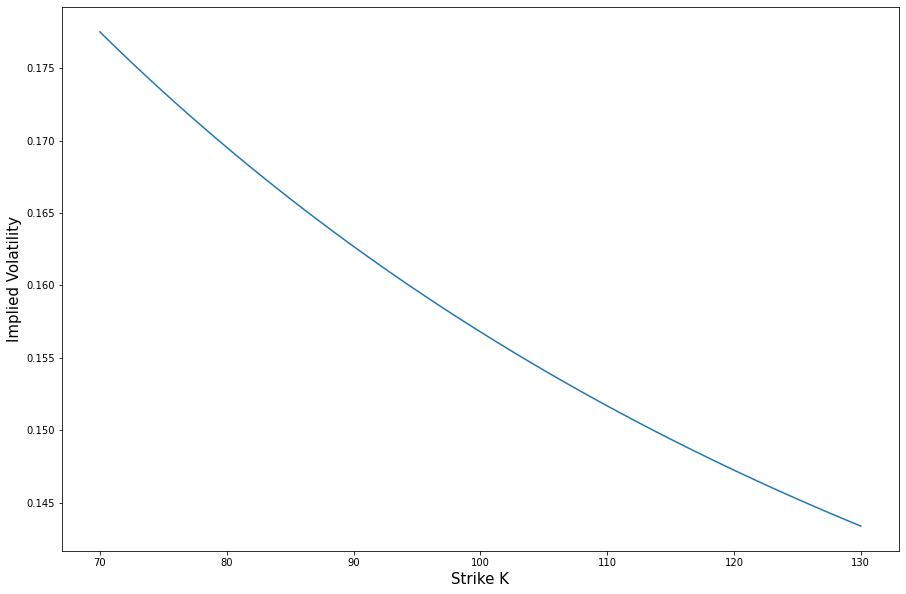

In [16]:
plt.figure(figsize = (15,10))
plt.plot(K_list, impliedsigma)
plt.xlabel('Strike K', fontsize=15)
plt.ylabel("Implied Volatility", fontsize=15)
plt.savefig('implied_volatility1.eps',format = 'eps')

In [17]:
# Now we fix constant local volatility
# Using implicit scheme
sigma = 0.157
a_diag, b_diag, c_diag, L, I = getmatrix(sigma)

newCall_price = []

for K in K_list:
    v_im = np.maximum(s - K, 0) # call option payoff
    
    for n in range(1,N+1):
        d = v_im           
        d[0] = 0       # Boundary operation at s_min
        d[M] = s_max - K*np.exp(-r*tau[n])          
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)     

    newCall_price.append(v_im[90])

In [18]:
new_impliedsigma = []
for i in range(61):
    j = impliedvol(S = 100, K = K_list[i], T = 1, r = 0.01, marketoptionPrice = newCall_price[i])
    new_impliedsigma.append(j)


In [19]:
new_local = pd.DataFrame(
    {'K': K_list,
     'Call Option Price':newCall_price,
     'Implied Volatility': new_impliedsigma,
    })
new_local.to_csv('new_local.csv', index = False, float_format="%.4f")  

In [20]:
new_local

,K,Call Option Price,Implied Volatility
0,70,30.739816,0.157141
1,71,29.763163,0.157118
2,72,28.789894,0.157097
3,73,27.820656,0.157078
4,74,26.856169,0.157059
...,...,...,...
56,126,0.630059,0.157011
57,127,0.565516,0.157018
58,128,0.507041,0.157024
59,129,0.454137,0.157031


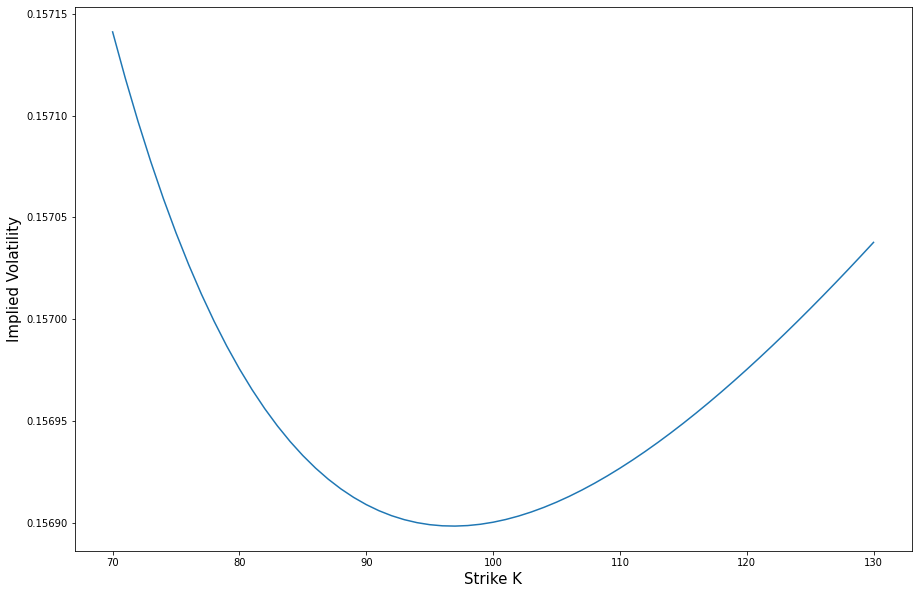

In [21]:
plt.figure(figsize = (15,10))
plt.plot(K_list, new_impliedsigma)
plt.xlabel('Strike K', fontsize=15)
plt.ylabel("Implied Volatility", fontsize=15)
plt.savefig('implied_volatility2.eps',format = 'eps')

# Down-and-in Barrier put option

$$\frac{\partial V}{\partial \tau} = \frac{\sigma(\tau, s)^2 s^2}{2}\frac{\partial^2 V}{\partial s^2} + rs\frac{\partial V}{\partial s} -rV, \tau>0 $$
$$V(0,s) = g(s) = (s-K)^{+} 1_{(s \leq B_{in})}, \tau=0 $$
$$V(\tau, B_{in}) = 0, \tau >0$$


In [22]:
#Local Volatility Model 
# Put Option Price, implicit scheme 
B_list = [60, 70, 80, 90]
K, r, T = 100, 0.01, 1

volatility = np.array(Volatility_function(tau[1], s))
a_diag, b_diag, c_diag, L, I = getmatrix(volatility)
# Running the implicit scheme
v_im = np.maximum(K - s, 0)

# Iteration of implicit scheme
for n in range(1,N+1):
    d = v_im   
    d[0] = K*np.exp(-r*tau[n]) 
    d[M] = 0
    v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   

    volatility =  np.array(Volatility_function((n+1)/N, s))
    a_diag, b_diag, c_diag, L, I = getmatrix(volatility)

Put_price = v_im[100 - s_min]


In [23]:
Put_price

5.730900036310575

In [24]:
# Down and out barrier put 
B_list = [60, 70, 80, 90]
outbarrier = []

for B in B_list:
    s_min = B 
    s_max = 300
    N, M = 1000, s_max - s_min  # we want the grid of x to be 5 

    # Setup of grids
    dtau = T/N
    dx = 1
    s = np.linspace(s_min, s_max, M+1)
    tau = np.linspace(0, T, N+1)

    volatility = np.array(Volatility_function(tau[1], s))
    a_diag, b_diag, c_diag, L, I = getmatrix(volatility)

    indicator = lambda x: 1 if x > B else 0
    indicator = np.vectorize(indicator)
    v_im = np.maximum(K - s, 0)* indicator(s)

    for n in range(1, N+1):
        d = v_im     
        d[0] = 0
        d[M] = 0
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d) 

        volatility =  np.array(Volatility_function((n+1)/N, s))
        a_diag, b_diag, c_diag, L, I = getmatrix(volatility)
    
    outbarrier.append(v_im[100-B])

In [25]:
localbarrier = pd.DataFrame(
    {
        'B': B_list,
        'Put Option Pirce': [Put_price]*4,
        'Down and out Barrier': outbarrier,
        'Down and in Barrier': [Put_price - x for x in outbarrier],
    }
)
localbarrier

,B,Put Option Pirce,Down and out Barrier,Down and in Barrier
0,60,5.7309,5.498773,0.232127
1,70,5.7309,4.499157,1.231743
2,80,5.7309,2.221413,3.509487
3,90,5.7309,0.271040,5.459860


In [26]:
# Constant volatility case
B_list = [60, 70, 80, 90]
K, r, T = 100, 0.01, 1
s_min, s_max = 10, 300
N, M = 1000, 290  # we want the grid of x to be 5 

# Setup of grids
dtau = T/N
dx = (s_max - s_min)/M
s = np.linspace(s_min, s_max, M+1)
tau = np.linspace(0, T, N+1)

sigma = 0.157
a_diag, b_diag, c_diag, L, I = getmatrix(sigma)

v_im = np.maximum(K - s, 0)

for n in range(1,N+1):
    d = v_im   
    d[0] = K*np.exp(-r*tau[n]) 
    d[M] = 0
    v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   

Put_const = v_im[100 -10]


In [27]:
Put_const

5.736997561300398

In [28]:
# Down and out barrier put 
outbarrier_new = []

for B in B_list:
    s_min = B 
    s_max = 300
    N, M = 1000, s_max - s_min  # we want the grid of x to be 5 

    # Setup of grids
    dtau = T/N
    dx = 1
    s = np.linspace(s_min, s_max, M+1)
    tau = np.linspace(0, T, N+1)

    volatility = 0.157
    a_diag, b_diag, c_diag, L, I = getmatrix(volatility)

    indicator = lambda x: 1 if x > B else 0
    indicator = np.vectorize(indicator)
    v_im = np.maximum(K - s, 0)* indicator(s)

    for n in range(1, N+1):
        d = v_im     
        d[0] = 0
        d[M] = 0
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d) 
    
    outbarrier_new.append(v_im[100-B])

In [29]:
constbarrier = pd.DataFrame(
    {
        'B': B_list,
        'Put Option Pirce': [Put_const]*4,
        'Down and out Barrier': outbarrier_new,
        'Down and in Barrier': [Put_const - x for x in outbarrier_new],
    }
)
constbarrier

,B,Put Option Pirce,Down and out Barrier,Down and in Barrier
0,60,5.736998,5.687471,0.049527
1,70,5.736998,5.024652,0.712345
2,80,5.736998,2.630731,3.106267
3,90,5.736998,0.307449,5.429548
